## Project 1: Flight Price Prediction (Regression)


In [309]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import mlflow
import mlflow.sklearn
import warnings
import pickle
import joblib
warnings.filterwarnings('ignore')

### Data Cleaning

In [311]:
# Load the dataset

df = pd.read_csv('Flight_Price.csv')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [471]:
df.shape

(10683, 11)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [36]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [313]:
#finding the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [315]:
#Drop missing due to very less entries 
df.dropna(inplace=True)

In [41]:
df.dtypes # datatypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

## Unique & Categorical Insights

In [45]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [47]:
for col in df.columns:
  print(f"{col}:\n Unique values:",df[col].nunique(),"\n", df[col].unique())
  print()
  print()

Airline:
 Unique values: 12 
 ['IndiGo' 'Air India' 'Jet Airways' 'SpiceJet' 'Multiple carriers' 'GoAir'
 'Vistara' 'Air Asia' 'Vistara Premium economy' 'Jet Airways Business'
 'Multiple carriers Premium economy' 'Trujet']


Date_of_Journey:
 Unique values: 44 
 ['24/03/2019' '1/05/2019' '9/06/2019' '12/05/2019' '01/03/2019'
 '24/06/2019' '12/03/2019' '27/05/2019' '1/06/2019' '18/04/2019'
 '9/05/2019' '24/04/2019' '3/03/2019' '15/04/2019' '12/06/2019'
 '6/03/2019' '21/03/2019' '3/04/2019' '6/05/2019' '15/05/2019'
 '18/06/2019' '15/06/2019' '6/04/2019' '18/05/2019' '27/06/2019'
 '21/05/2019' '06/03/2019' '3/06/2019' '15/03/2019' '3/05/2019'
 '9/03/2019' '6/06/2019' '24/05/2019' '09/03/2019' '1/04/2019'
 '21/04/2019' '21/06/2019' '27/03/2019' '18/03/2019' '12/04/2019'
 '9/04/2019' '1/03/2019' '03/03/2019' '27/04/2019']


Source:
 Unique values: 5 
 ['Banglore' 'Kolkata' 'Delhi' 'Chennai' 'Mumbai']


Destination:
 Unique values: 6 
 ['New Delhi' 'Banglore' 'Cochin' 'Kolkata' 'Delhi' 'Hyde

## Handling Outliers

In [321]:
numerical_cols = df.select_dtypes(exclude='object').columns
numerical_cols

Index(['Price'], dtype='object')

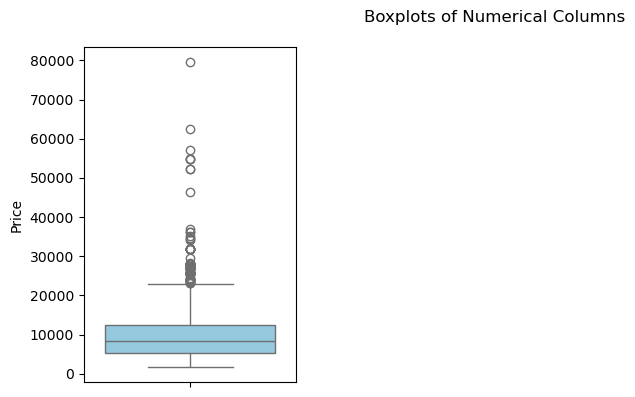

In [323]:
plt.figure(figsize=(10, 4))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

**Observation**: There is a possibility of high flight prices for some airlines in both business and economy classes. Since there are some outliers in the price feature, I replaced values greater than or equal to 40K with the median.

In [325]:
df['Price']=np.where(df['Price']>=40000,df['Price'].median(),df['Price'])

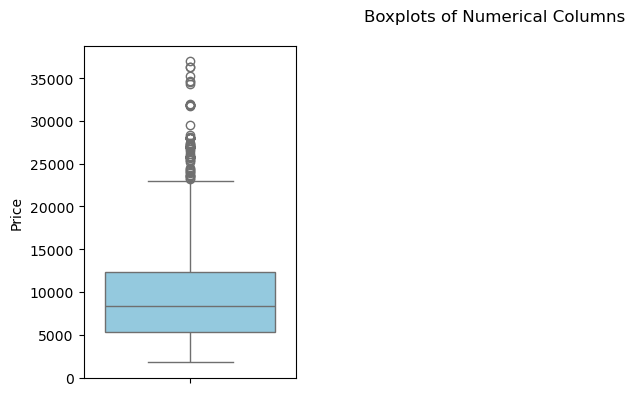

In [327]:
plt.figure(figsize=(10, 4))
plt.suptitle('Boxplots of Numerical Columns')
for i in range(0, len(numerical_cols)):
    plt.subplot(1, 4, i+1)
    sns.boxplot(y=df[numerical_cols[i]],color='skyblue',)
    plt.tight_layout()

## Data Preprocessing

## Feature Creation

In [329]:
# Convert date and time columns
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'])
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Day'] = df['Date_of_Journey'].dt.day

In [331]:
# dropping unwanted columns
df.drop('Date_of_Journey', axis=1, inplace=True)

In [333]:
# Convert departure and arrival times
df['Dep_Time'] = pd.to_datetime(df['Dep_Time']).dt.strftime('%H:%M')
df['Arrival_Time'] = pd.to_datetime(df['Arrival_Time']).dt.strftime('%H:%M')
df['Dep_Hour'] = pd.to_datetime(df['Dep_Time']).dt.hour
df['Dep_Minute'] = pd.to_datetime(df['Dep_Time']).dt.minute
df['Arrival_Hour'] = pd.to_datetime(df['Arrival_Time']).dt.hour
df['Arrival_Minute'] = pd.to_datetime(df['Arrival_Time']).dt.minute

In [335]:
df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897.0,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662.0,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882.0,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218.0,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302.0,3,1,16,50,21,35


In [337]:
# dropping unwanted columns
df.drop('Dep_Time', axis=1, inplace=True)
df.drop('Arrival_Time', axis=1, inplace=True)

In [339]:
# Convert duration to minutes
def convert_to_minutes(duration):
    hours = 0
    minutes = 0

    if 'h' in duration:
        hours = int(duration.split('h')[0])
        duration = duration.split('h')[1]  # Get remaining part after 'h'

    if 'm' in duration:
        minutes = int(duration.replace('m', ''))

    return hours * 60 + minutes

In [341]:
# Process duration
df['Duration_mins'] = df['Duration'].apply(convert_to_minutes)

In [31]:
df.to_csv('feature.csv')

In [343]:
df.dtypes

Airline             object
Source              object
Destination         object
Route               object
Duration            object
Total_Stops         object
Additional_Info     object
Price              float64
Journey_Month        int32
Journey_Day          int32
Dep_Hour             int32
Dep_Minute           int32
Arrival_Hour         int32
Arrival_Minute       int32
Duration_mins        int64
dtype: object

In [345]:
df['Price_per_minute'] = df['Price'] / df['Duration_mins']

In [347]:
df.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,IndiGo,Banglore,New Delhi,BLR ? DEL,2h 50m,non-stop,No info,3897.0,3,24,22,20,1,10,170,22.923529
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,7h 25m,2 stops,No info,7662.0,5,1,5,50,13,15,445,17.217978
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,19h,2 stops,No info,13882.0,6,9,9,25,4,25,1140,12.177193
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,5h 25m,1 stop,No info,6218.0,5,12,18,5,23,30,325,19.132308
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,4h 45m,1 stop,No info,13302.0,3,1,16,50,21,35,285,46.673684


In [349]:
# dropping unwanted columns

df.drop('Duration', axis=1, inplace=True)

### Handling categorical data

In [351]:
#Finding the categorical value
column=[column for column in df.columns if df[column].dtype=='object']
column

['Airline', 'Source', 'Destination', 'Route', 'Total_Stops', 'Additional_Info']

In [353]:
#Finding the continuous value
continuous_col =[column for column in df.columns if df[column].dtype!='object']
continuous_col

['Price',
 'Journey_Month',
 'Journey_Day',
 'Dep_Hour',
 'Dep_Minute',
 'Arrival_Hour',
 'Arrival_Minute',
 'Duration_mins',
 'Price_per_minute']

In [355]:
categorical = df[column]
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,No info
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,No info
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,No info
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,No info
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,No info


In [357]:
categorical['Airline'].value_counts()

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64

<Axes: xlabel='Airline', ylabel='Price'>

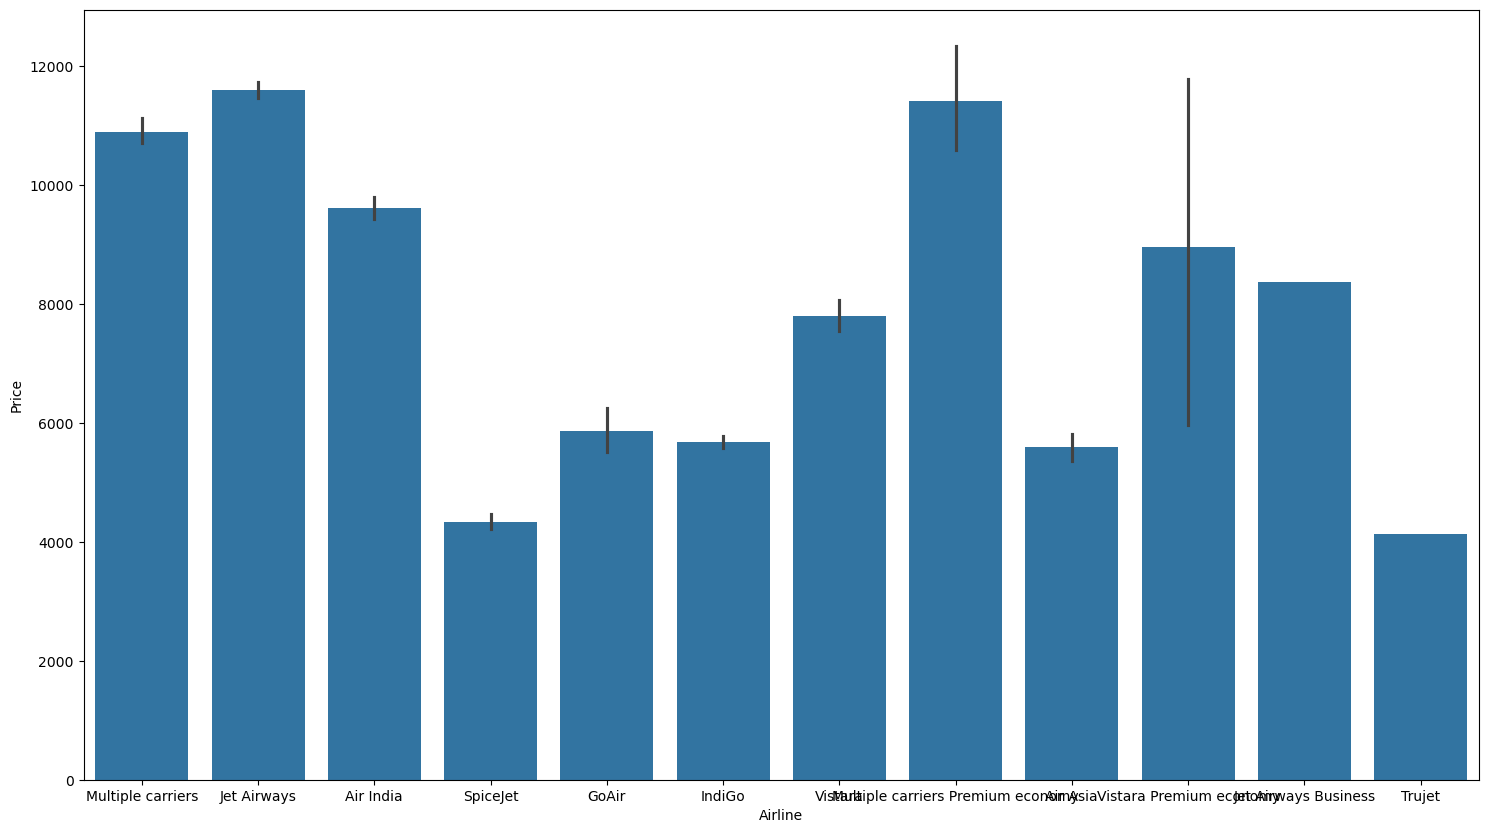

In [359]:
#Airline vs Price Analysis
plt.figure(figsize=(18,10))
sns.barplot(x='Airline',y='Price',data=df.sort_values('Price',ascending=False))

<Axes: xlabel='Total_Stops', ylabel='Price'>

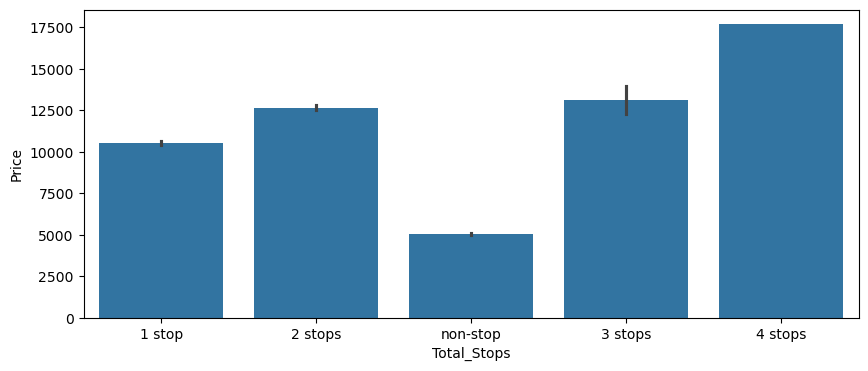

In [361]:
#Perform Total_Stops vs Price Analysis
plt.figure(figsize=(10,4))
sns.barplot(x='Total_Stops',y='Price',data=df.sort_values('Price',ascending=False))

In [363]:
# As Airline is Nominal Categorical data we will perform OneHotEncoding
Airline=pd.get_dummies(categorical['Airline'], dtype=int, drop_first=False)

In [365]:
Airline.head()

,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0


In [367]:
categorical['Source'].value_counts()

Source
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: count, dtype: int64

<Axes: xlabel='Source', ylabel='Price'>

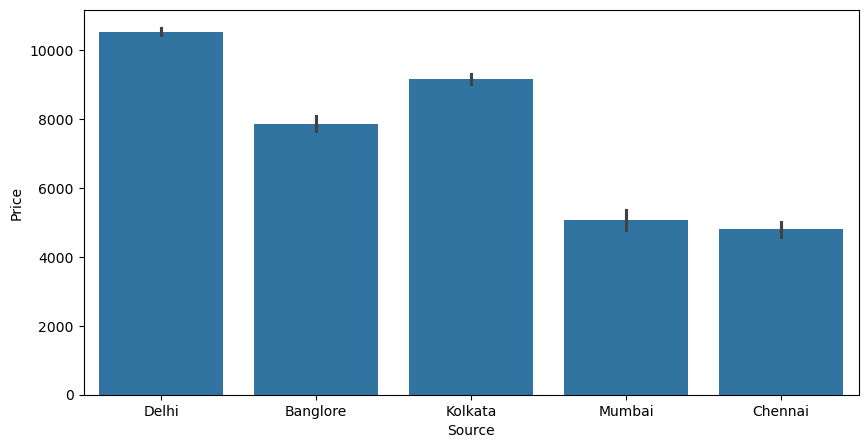

In [369]:
#Source vs Price
plt.figure(figsize=(10,5))
sns.barplot(x='Source',y='Price',data=df.sort_values('Price',ascending=False))

In [371]:
#encoding of source column
source = pd.get_dummies(categorical['Source'], dtype=int, drop_first=False)
source.columns = ['Source_' + str(col) for col in source.columns]
source.head()

,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,1,0,0
3,0,0,0,1,0
4,1,0,0,0,0


In [373]:
categorical['Destination'].value_counts()

Destination
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: count, dtype: int64

<Axes: xlabel='Destination', ylabel='Price'>

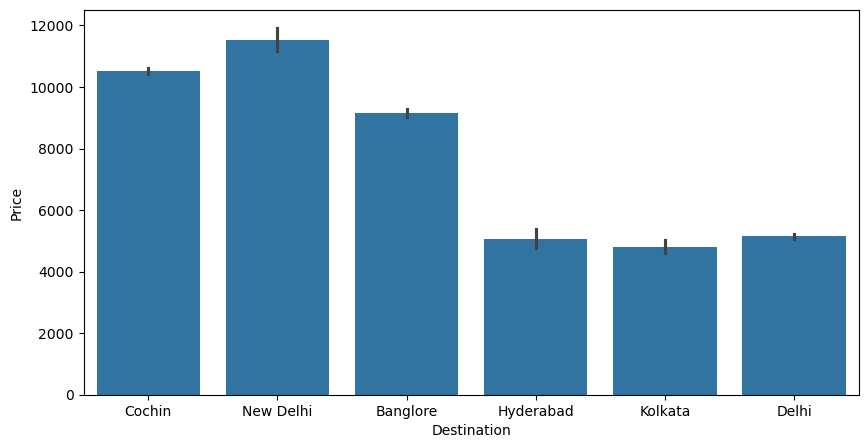

In [375]:
plt.figure(figsize=(10,5))
sns.barplot(x='Destination',y='Price',data=df.sort_values('Price',ascending=False))

In [377]:
#encoding of destination column
destination=pd.get_dummies(categorical['Destination'], dtype=int,drop_first=False)
destination.columns = ['Destination_' + str(col) for col in destination.columns]
destination.head()

,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,0,0,0,0,1
1,1,0,0,0,0,0
2,0,1,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,0,1


In [379]:
# Split Route into multiple columns
categorical['Route'].value_counts()

Route
DEL ? BOM ? COK          2376
BLR ? DEL                1552
CCU ? BOM ? BLR           979
CCU ? BLR                 724
BOM ? HYD                 621
                         ... 
CCU ? VTZ ? BLR             1
CCU ? IXZ ? MAA ? BLR       1
BOM ? COK ? MAA ? HYD       1
BOM ? CCU ? HYD             1
BOM ? BBI ? HYD             1
Name: count, Length: 128, dtype: int64

In [381]:
categorical['Route1']=categorical['Route'].str.split('?').str[0]
categorical['Route2']=categorical['Route'].str.split('?').str[1]
categorical['Route3']=categorical['Route'].str.split('?').str[2]
categorical['Route4']=categorical['Route'].str.split('?').str[3]
categorical['Route5']=categorical['Route'].str.split('?').str[4]

In [383]:
categorical.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,No info,BLR,DEL,NaN,NaN,NaN
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,No info,CCU,IXR,BBI,BLR,NaN
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,No info,DEL,LKO,BOM,COK,NaN
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,No info,CCU,NAG,BLR,NaN,NaN
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,No info,BLR,NAG,DEL,NaN,NaN


In [385]:
categorical.drop('Route', axis=1, inplace=True)

In [387]:
categorical.isnull().sum()

Airline                0
Source                 0
Destination            0
Total_Stops            0
Additional_Info        0
Route1                 0
Route2                 0
Route3              3491
Route4              9116
Route5             10636
dtype: int64

In [389]:
categorical.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info',
       'Route1', 'Route2', 'Route3', 'Route4', 'Route5'],
      dtype='object')

In [391]:
for i in ['Route3', 'Route4', 'Route5']:
    categorical[i].fillna('None',inplace=True)

In [393]:
categorical.isnull().sum()

Airline            0
Source             0
Destination        0
Total_Stops        0
Additional_Info    0
Route1             0
Route2             0
Route3             0
Route4             0
Route5             0
dtype: int64

In [395]:
for i in categorical.columns:
    print('{} has total {} categories'.format(i,len(categorical[i].value_counts())))

Airline has total 12 categories
Source has total 5 categories
Destination has total 6 categories
Total_Stops has total 5 categories
Additional_Info has total 10 categories
Route1 has total 5 categories
Route2 has total 45 categories
Route3 has total 30 categories
Route4 has total 14 categories
Route5 has total 6 categories


<Axes: xlabel='Arrival_Hour', ylabel='Price'>

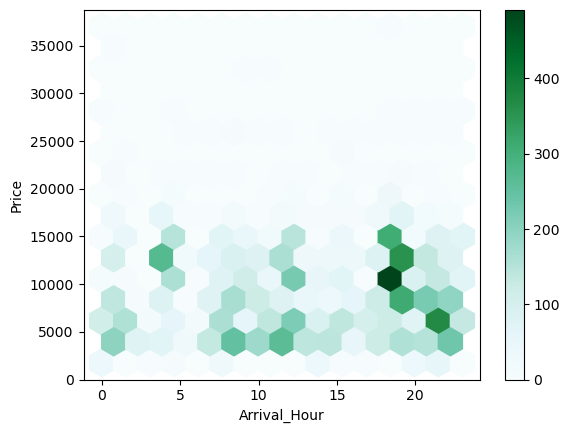

In [397]:
df.plot.hexbin(x='Arrival_Hour',y='Price',gridsize=15)

In [399]:
# Applying label encoder
encoder = LabelEncoder()

In [401]:
for i in ['Route1', 'Route2', 'Route3', 'Route4', 'Route5']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [403]:
categorical.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5
0,IndiGo,Banglore,New Delhi,non-stop,No info,0,13,29,13,5
1,Air India,Kolkata,Banglore,2 stops,No info,2,25,1,3,5
2,Jet Airways,Delhi,Cochin,2 stops,No info,3,32,4,5,5
3,IndiGo,Kolkata,Banglore,1 stop,No info,2,34,3,13,5
4,IndiGo,Banglore,New Delhi,1 stop,No info,0,34,8,13,5


In [405]:
for i in ['Additional_Info']:
    categorical[i]=encoder.fit_transform(categorical[i])

In [407]:
categorical['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [409]:
# encoding Total stops
dict={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}
categorical['Total_Stops']=categorical['Total_Stops'].map(dict)

In [411]:
categorical['Total_Stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10682, dtype: int64

In [413]:
categorical.drop('Source', axis=1, inplace=True)
categorical.drop('Destination', axis=1, inplace=True)
categorical.drop('Airline', axis=1, inplace=True)

In [415]:
final_df=pd.concat([categorical,Airline,source,destination,df[continuous_col]],axis=1)

In [417]:
final_df.head()

,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,0,8,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3897.0,3,24,22,20,1,10,170,22.923529
1,2,8,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,7662.0,5,1,5,50,13,15,445,17.217978
2,2,8,3,32,4,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,13882.0,6,9,9,25,4,25,1140,12.177193
3,1,8,2,34,3,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,6218.0,5,12,18,5,23,30,325,19.132308
4,1,8,0,34,8,13,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,13302.0,3,1,16,50,21,35,285,46.673684


In [419]:
pd.set_option('display.max_columns',39)
final_df.head()

,Total_Stops,Additional_Info,Route1,Route2,Route3,Route4,Route5,Air Asia,Air India,GoAir,IndiGo,Jet Airways,Jet Airways Business,Multiple carriers,Multiple carriers Premium economy,SpiceJet,Trujet,Vistara,Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Price,Journey_Month,Journey_Day,Dep_Hour,Dep_Minute,Arrival_Hour,Arrival_Minute,Duration_mins,Price_per_minute
0,0,8,0,13,29,13,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3897.0,3,24,22,20,1,10,170,22.923529
1,2,8,2,25,1,3,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,7662.0,5,1,5,50,13,15,445,17.217978
2,2,8,3,32,4,5,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,13882.0,6,9,9,25,4,25,1140,12.177193
3,1,8,2,34,3,13,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,6218.0,5,12,18,5,23,30,325,19.132308
4,1,8,0,34,8,13,5,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,13302.0,3,1,16,50,21,35,285,46.673684


### EDA

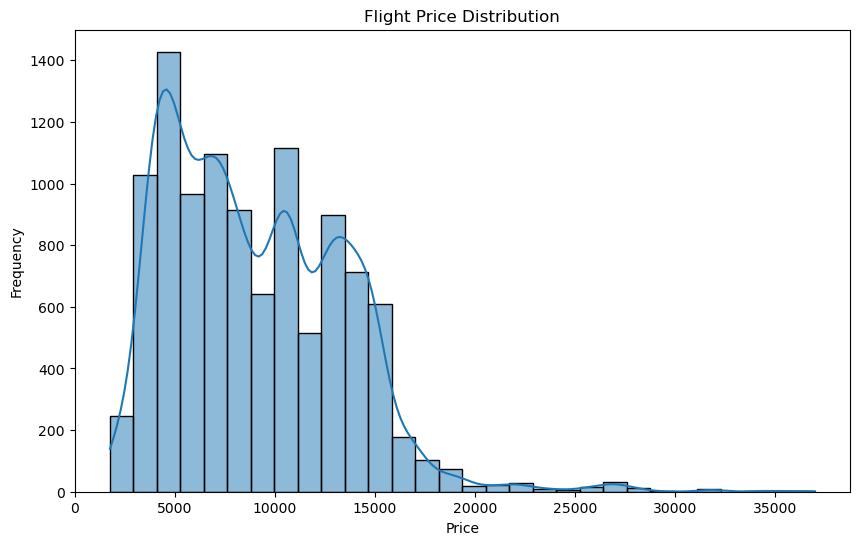

In [421]:
# Plot flight price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Flight Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

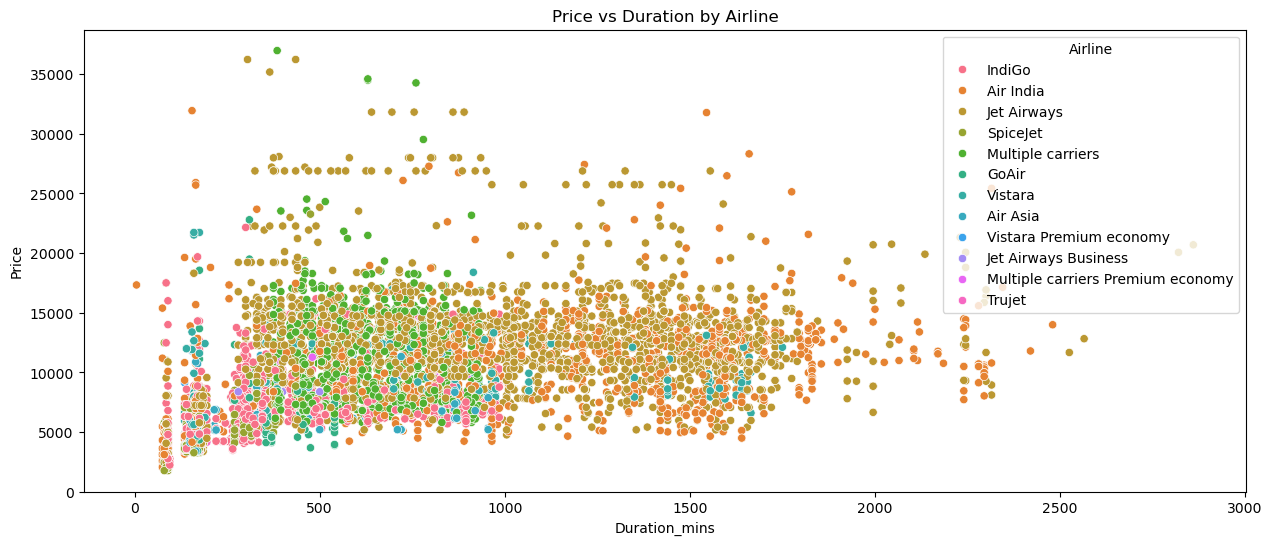

In [423]:
# Price vs Duration by Airline
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df, x='Duration_mins', y='Price', hue='Airline')
plt.title('Price vs Duration by Airline')
plt.show()

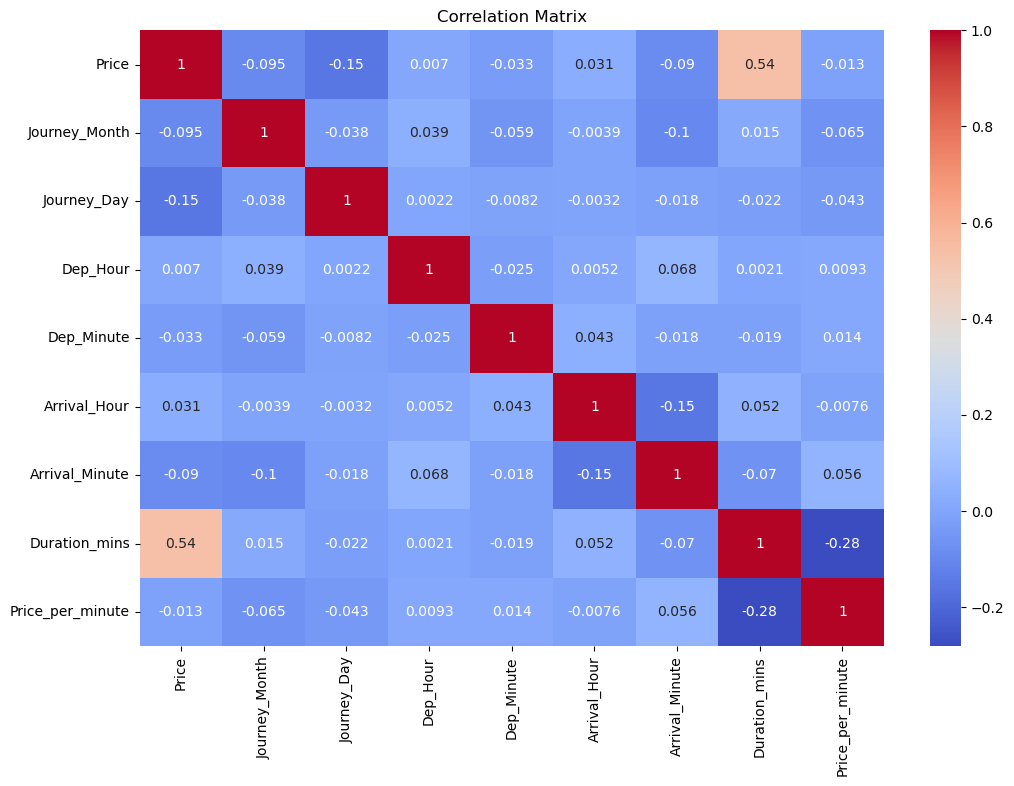

In [425]:
# Correlation heatmap
correlation_matrix = df.select_dtypes(exclude='object').corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [427]:
# Top 6 Most Expensive and Cheapest Routes
route_prices = df.groupby(['Source', 'Destination'])['Price'].mean().reset_index()
top_expensive = route_prices.nlargest(10, 'Price')
top_cheapest = route_prices.nsmallest(10, 'Price')

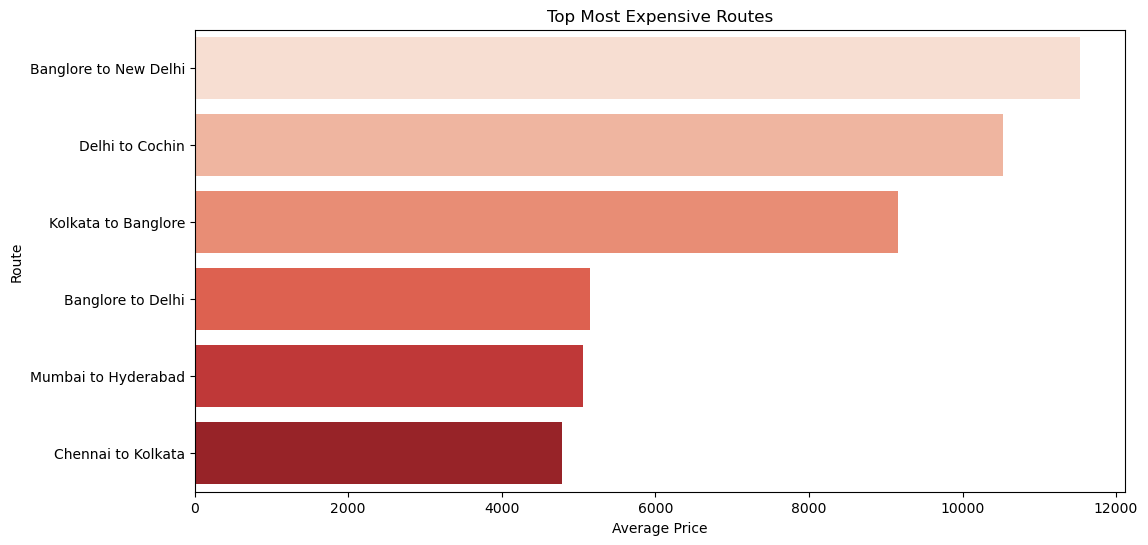

In [429]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_expensive.assign(Route=top_expensive['Source'] + ' to ' + top_expensive['Destination']), palette='Reds')
plt.title('Top Most Expensive Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

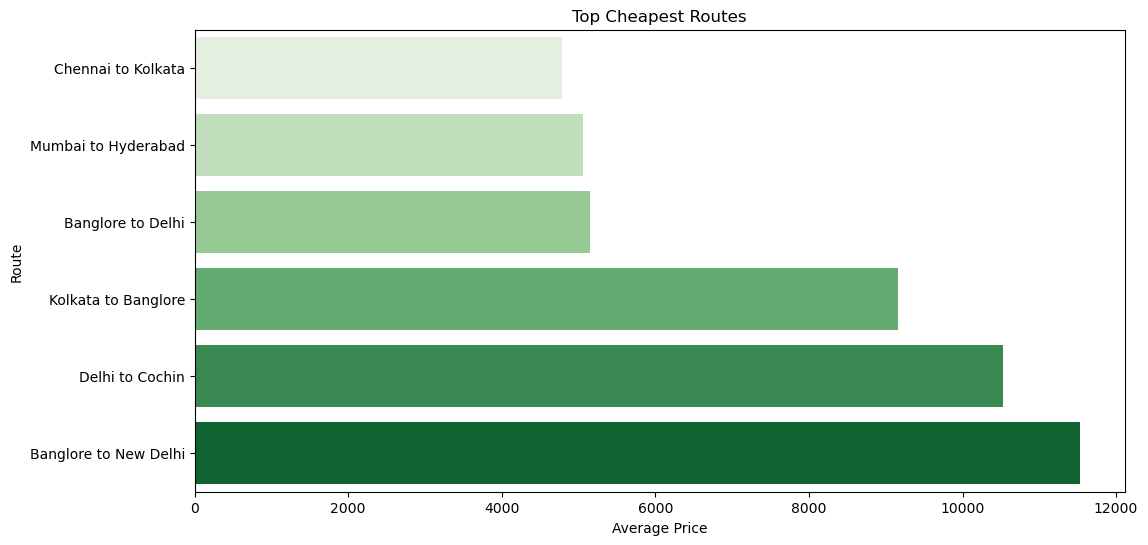

In [431]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='Route', data=top_cheapest.assign(Route=top_cheapest['Source'] + ' to ' + top_cheapest['Destination']), palette='Greens')
plt.title('Top Cheapest Routes')
plt.xlabel('Average Price')
plt.ylabel('Route')
plt.show()

## Standard scaling for price column

In [433]:
scaler = StandardScaler()
final_df['Price'] = scaler.fit_transform(final_df[['Price']])

## Feature importances using Random Forest(Regression)

In [481]:
X = final_df.drop(columns=['Price'])
y = final_df['Price']

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top features
feature_importance_df

,Feature,Importance
36,Duration_mins,6.262622e-01
37,Price_per_minute,2.987793e-01
1,Additional_Info,1.614508e-02
11,Jet Airways,1.249810e-02
0,Total_Stops,1.036604e-02
31,Journey_Day,8.179243e-03
3,Route2,4.863544e-03
4,Route3,4.423637e-03
5,Route4,4.407042e-03
30,Journey_Month,3.331344e-03


In [483]:
# Seperate the dataset in X and Y columns
X=final_df.drop('Price', axis=1)
y=df['Price']

In [485]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [487]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

In [489]:
# Hyperparameter grids
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 6]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20]
    },
    'Ridge Regression': {
        'alpha': [0.1, 1, 10]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1, 10]
    }
}

In [471]:
# Initialize MLflow
mlflow.set_experiment("Flights - Price Prediction")

2025/04/14 15:11:50 INFO mlflow.tracking.fluent: Experiment with name 'Flights - Price Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/GUVI-DS/Mini-Project4/mlruns/467175060156977180', creation_time=1744623710240, experiment_id='467175060156977180', last_update_time=1744623710240, lifecycle_stage='active', name='Flights - Price Prediction', tags={}>

In [491]:
trained_models = {}
best_model = None
best_r2 = float('-inf')

Training Linear Regression...

Linear Regression Performance:
  RMSE: 2611.2007
  MAE: 1742.9851
  R² Score: 0.6671
----------------------------------------


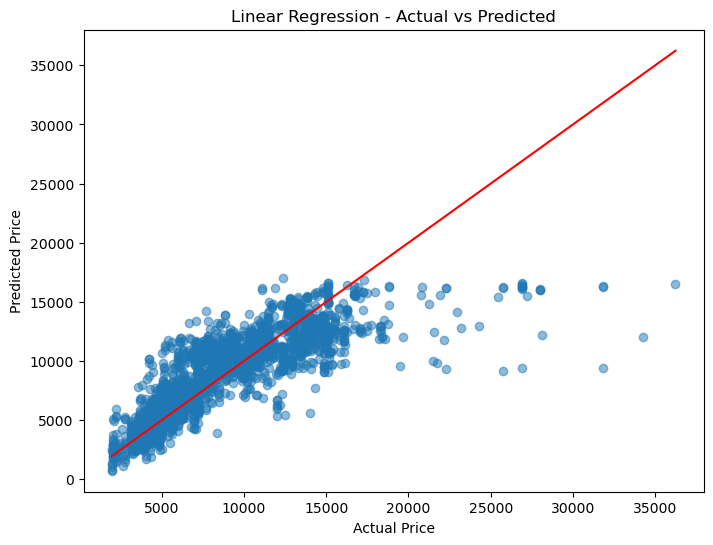

2025/04/14 15:32:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Random Forest...

Random Forest Performance:
  RMSE: 389.0110
  MAE: 100.7246
  R² Score: 0.9926
----------------------------------------


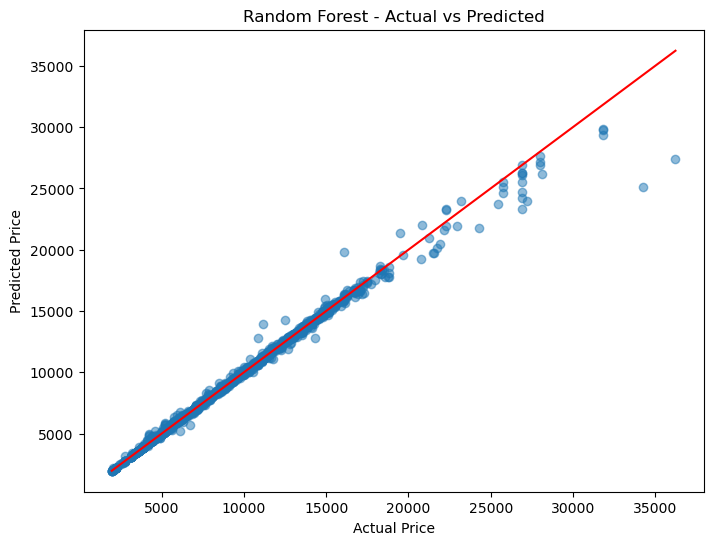

Tuning Random Forest...
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

Random Forest Performance after Tuning:
  RMSE: 387.9581
  MAE: 97.0009
  R² Score: 0.9927
----------------------------------------


2025/04/14 15:34:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training XGBoost...

XGBoost Performance:
  RMSE: 386.8960
  MAE: 152.4266
  R² Score: 0.9927
----------------------------------------


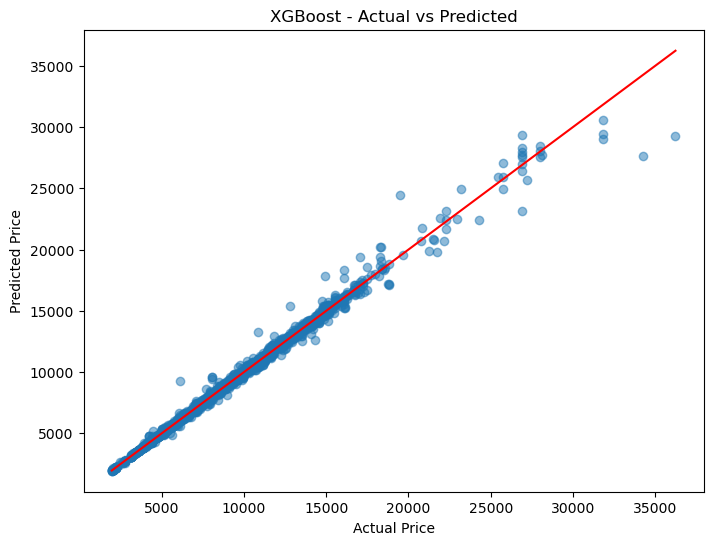

Tuning XGBoost...
Best params for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

XGBoost Performance after Tuning:
  RMSE: 367.2790
  MAE: 132.6412
  R² Score: 0.9934
----------------------------------------


2025/04/14 15:34:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Gradient Boosting...

Gradient Boosting Performance:
  RMSE: 651.8158
  MAE: 399.4867
  R² Score: 0.9793
----------------------------------------


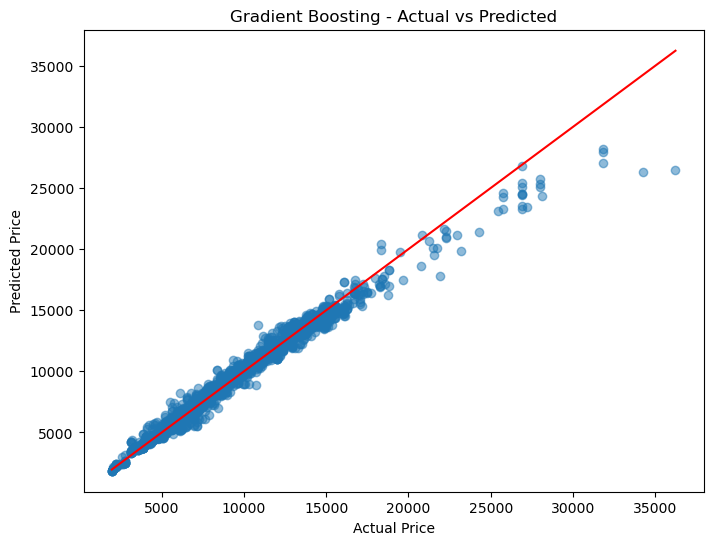

Tuning Gradient Boosting...
Best params for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200}

Gradient Boosting Performance after Tuning:
  RMSE: 332.5418
  MAE: 118.7853
  R² Score: 0.9946
----------------------------------------


2025/04/14 15:34:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Decision Tree...

Decision Tree Performance:
  RMSE: 643.4483
  MAE: 152.8989
  R² Score: 0.9798
----------------------------------------


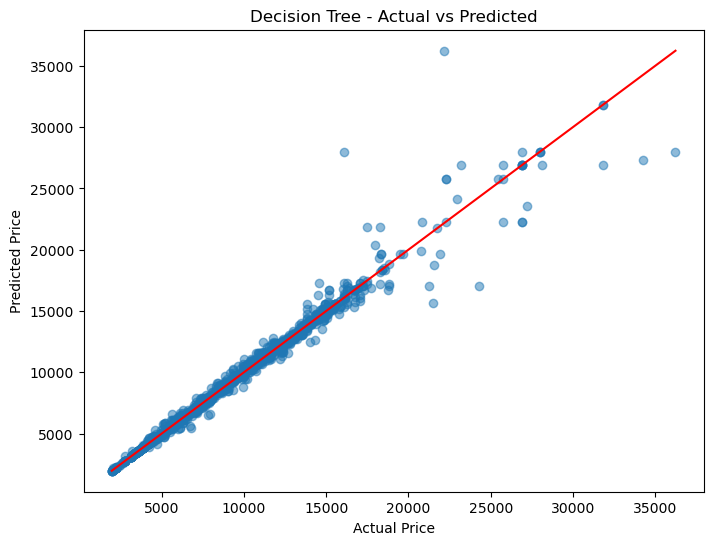

Tuning Decision Tree...
Best params for Decision Tree: {'max_depth': 20}

Decision Tree Performance after Tuning:
  RMSE: 633.0573
  MAE: 153.5265
  R² Score: 0.9804
----------------------------------------


2025/04/14 15:34:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Ridge Regression...

Ridge Regression Performance:
  RMSE: 2610.9804
  MAE: 1742.5906
  R² Score: 0.6671
----------------------------------------


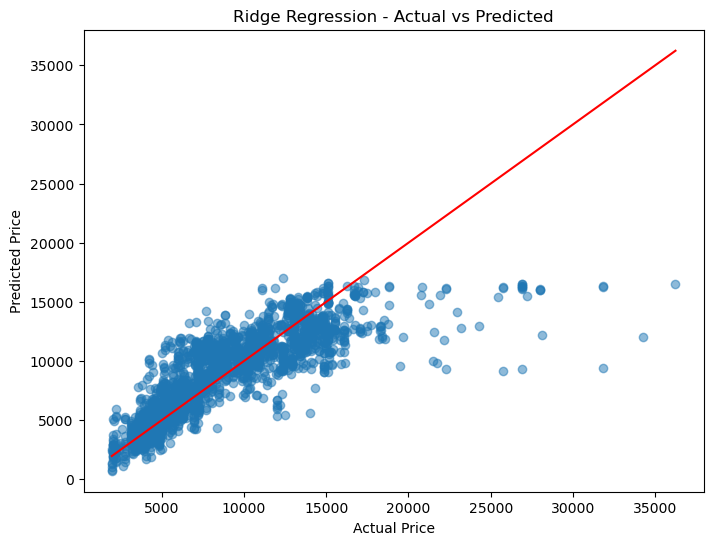

Tuning Ridge Regression...
Best params for Ridge Regression: {'alpha': 10}

Ridge Regression Performance after Tuning:
  RMSE: 2610.6013
  MAE: 1741.7281
  R² Score: 0.6672
----------------------------------------


2025/04/14 15:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Training Lasso Regression...

Lasso Regression Performance:
  RMSE: 2611.1213
  MAE: 1741.3933
  R² Score: 0.6671
----------------------------------------


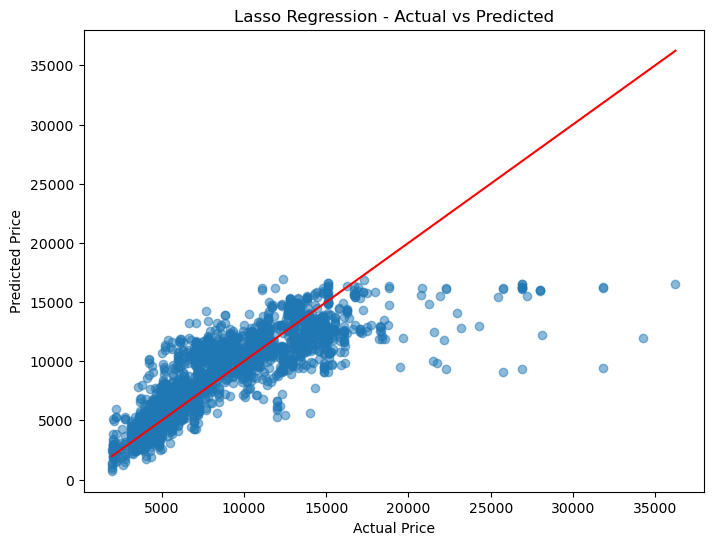

Tuning Lasso Regression...
Best params for Lasso Regression: {'alpha': 0.1}

Lasso Regression Performance after Tuning:
  RMSE: 2611.2253
  MAE: 1742.8429
  R² Score: 0.6671
----------------------------------------


2025/04/14 15:35:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Model: Gradient Boosting with R²: 0.99
All models trained, tuned, and logged in MLflow!


In [493]:
# Train, tune, save, and track models
for name, model in models.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} Performance:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-" * 40)

    # Track best model
    if r2 > best_r2:
        best_r2 = r2
        best_model = name

    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.title(f"{name} - Actual vs Predicted")
    plt.show()

    # Hyperparameter tuning
    if name in param_grids:
        print(f"Tuning {name}...")
        grid_search = GridSearchCV(model, param_grid=param_grids[name], scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        model = grid_search.best_estimator_
        y_pred = model.predict(X_test)

        # Re-evaluate
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Best params for {name}: {grid_search.best_params_}")
        print(f"\n{name} Performance after Tuning:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE: {mae:.4f}")
        print(f"  R² Score: {r2:.4f}")
        print("-" * 40)

        if r2 > best_r2:
            best_r2 = r2
            best_model = name

    # MLflow logging
    with mlflow.start_run(run_name=name):
        if name in param_grids:
            for param, value in grid_search.best_params_.items():
                mlflow.log_param(param, value)

        mlflow.log_metrics({"RMSE": rmse, "MAE": mae, "R2": r2})
        mlflow.sklearn.log_model(model, name)

    # Save model
    trained_models[name] = model
    with open(f"{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

print(f"Best Model: {best_model} with R²: {best_r2:.2f}")
print("All models trained, tuned, and logged in MLflow!")

## Cross Validation

In [495]:
# Define the model
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Define K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation
cv_scores = cross_val_score(gb, X, y, cv=kf, scoring='r2')

# Print all 5 scores
print(f"All 5-Fold Scores: {cv_scores}")
print()
# Compare Mean and Standard Deviation
print(f"Mean R2 Score: {np.mean(cv_scores):.2f}")

All 5-Fold Scores: [0.97925446 0.98259726 0.97940884 0.97743726 0.97967565]

Mean R2 Score: 0.98


In [684]:
final_df.to_csv('Cleaned.csv')

In [497]:
# Load the model
model = joblib.load(r"D:\GUVI-DS\Mini-Project4\Reg_model\Gradient Boosting_model.pkl")

# Check the model's input features
print(model.feature_names_in_)

['Total_Stops' 'Additional_Info' 'Route1' 'Route2' 'Route3' 'Route4'
 'Route5' 'Air Asia' 'Air India' 'GoAir' 'IndiGo' 'Jet Airways'
 'Jet Airways Business' 'Multiple carriers'
 'Multiple carriers Premium economy' 'SpiceJet' 'Trujet' 'Vistara'
 'Vistara Premium economy' 'Source_Banglore' 'Source_Chennai'
 'Source_Delhi' 'Source_Kolkata' 'Source_Mumbai' 'Destination_Banglore'
 'Destination_Cochin' 'Destination_Delhi' 'Destination_Hyderabad'
 'Destination_Kolkata' 'Destination_New Delhi' 'Journey_Month'
 'Journey_Day' 'Dep_Hour' 'Dep_Minute' 'Arrival_Hour' 'Arrival_Minute'
 'Duration_mins' 'Price_per_minute']
